In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [4]:
EMOTIONS = ['angry','disgust','fear','happy','sad','surprise','neutral']
IMG_SIZE = (64, 64)
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# — FER-2013_sampled is right under the project root
SAMPLE_DIR = os.path.join(BASE_DIR, "FER-2013_sampled")
TRAIN_DIR = os.path.join(SAMPLE_DIR, r'C:\Users\Haya Osama\Downloads\Digital_Project\Emoji-Detection-System\FER-2013_sampled\FER-2013_sampled\train_balanced_7000')
# Check class distribution 
class_counts = {}
for emotion in EMOTIONS: 
    path = os.path.join(TRAIN_DIR, emotion)
    count = len(os.listdir(path))
    class_counts[emotion] = count

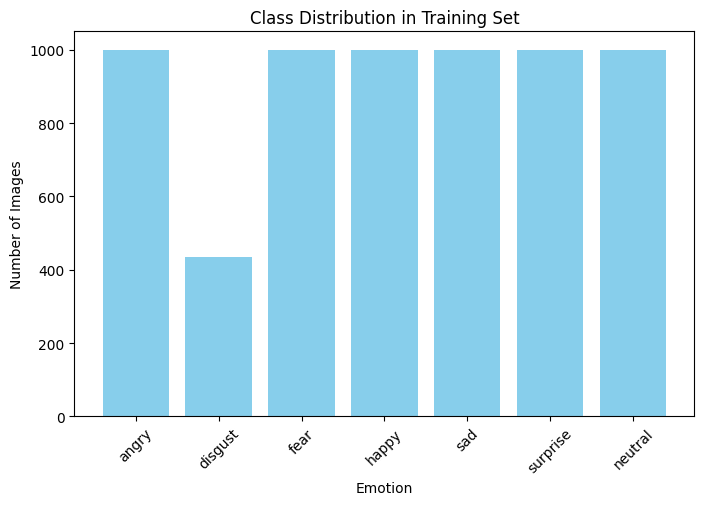

In [ ]:
# Plot class distribution 
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Class Distribution in Training Set")
plt.xlabel("Emotion") 
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

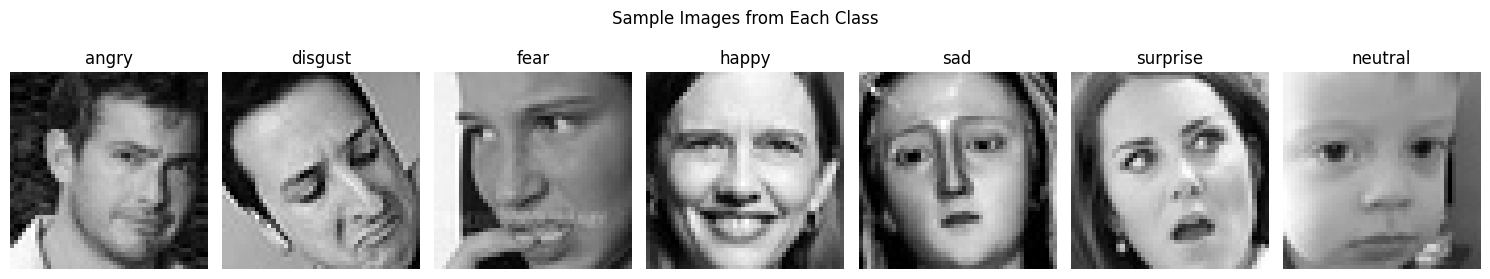

In [11]:
# Visualize sample images
fig, axes = plt.subplots(1, len(EMOTIONS), figsize=(15, 3))
for idx, emotion in enumerate(EMOTIONS):
    emo_path = os.path.join(TRAIN_DIR, emotion)
    img_name = os.listdir(emo_path)[0]
    img = Image.open(os.path.join(emo_path, img_name)).convert("L")
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(emotion)
    axes[idx].axis("off")
plt.suptitle("Sample Images from Each Class")
plt.tight_layout()
plt.show()

In [12]:
# Analyze image properties (on a small sample)
img_shapes = []
intensities = []

for emotion in EMOTIONS:
    folder = os.path.join(TRAIN_DIR, emotion)
    for img_name in os.listdir(folder)[:20]:  # Limit to 20 for speed
        img = Image.open(os.path.join(folder, img_name)).convert("L")
        arr = np.array(img)
        img_shapes.append(arr.shape)
        intensities.append(arr.ravel()) # Flatten to 1D for intensity analysis

Unique image shapes: {(48, 48)}


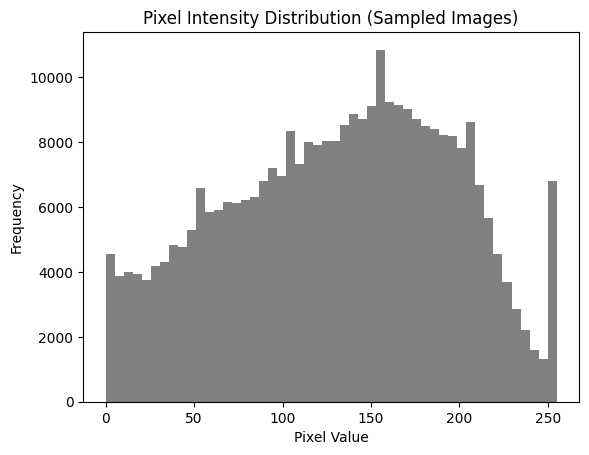

In [13]:
# Check average shape (expecting uniform if already cleaned)
unique_shapes = set(img_shapes)
print("Unique image shapes:", unique_shapes)

# Plot intensity distribution
flat_pixels = np.concatenate(intensities)
plt.hist(flat_pixels, bins=50, color='gray')
plt.title("Pixel Intensity Distribution (Sampled Images)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


In [16]:
#Check for duplicates or Corrupt Images 
def check_duplicates_and_corrupt_images(directory):
    seen = set()
    duplicates = []
    corrupt_images = []

    for emotion in EMOTIONS:
        path = os.path.join(directory, emotion)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()  # Check if image is corrupt
                img_hash = hash(img.tobytes())
                if img_hash in seen:
                    duplicates.append(img_path)
                else:
                    seen.add(img_hash)
            except (IOError, SyntaxError) as e:
                corrupt_images.append(img_path)

    return duplicates, corrupt_images


In [17]:
import hashlib

hashes = set()
duplicates = []

for cls in EMOTIONS:
    for img_name in os.listdir(os.path.join(TRAIN_DIR, cls)):
        img_path = os.path.join(TRAIN_DIR, cls, img_name)
        with open(img_path, 'rb') as f:
            hash_val = hashlib.md5(f.read()).hexdigest()
            if hash_val in hashes:
                duplicates.append(img_path)
            else:
                hashes.add(hash_val)

print("Duplicate images found:", len(duplicates))


Duplicate images found: 145


In [ ]:
import shutil

save_path = os.path.join(TRAIN_DIR, "duplicates_found")
os.makedirs(save_path, exist_ok=True)

for dup in duplicates:
    try:
        shutil.move(dup, os.path.join(save_path, os.path.basename(dup)))
        print(f"Moved: {dup}")
    except Exception as e:
        print(f"Failed to move {dup}: {e}") 


Moved: C:\Users\Haya Osama\Downloads\Digital_Project\Emoji-Detection-System\FER-2013_sampled\FER-2013_sampled\train_balanced_7000\angry\Training_267631.jpg
Moved: C:\Users\Haya Osama\Downloads\Digital_Project\Emoji-Detection-System\FER-2013_sampled\FER-2013_sampled\train_balanced_7000\angry\Training_3125398.jpg
Moved: C:\Users\Haya Osama\Downloads\Digital_Project\Emoji-Detection-System\FER-2013_sampled\FER-2013_sampled\train_balanced_7000\angry\Training_31835561.jpg
Moved: C:\Users\Haya Osama\Downloads\Digital_Project\Emoji-Detection-System\FER-2013_sampled\FER-2013_sampled\train_balanced_7000\angry\Training_44516923.jpg
Moved: C:\Users\Haya Osama\Downloads\Digital_Project\Emoji-Detection-System\FER-2013_sampled\FER-2013_sampled\train_balanced_7000\angry\Training_80018116.jpg
Moved: C:\Users\Haya Osama\Downloads\Digital_Project\Emoji-Detection-System\FER-2013_sampled\FER-2013_sampled\train_balanced_7000\angry\Training_91034450.jpg
Moved: C:\Users\Haya Osama\Downloads\Digital_Project\Em

In [ ]:
import hashlib

def check_and_move_bad_images(directory, label):
    seen = set()
    duplicates = []
    corrupt_images = []

    save_dup_path = os.path.join(directory, f"{label}_duplicates_found")
    save_corrupt_path = os.path.join(directory, f"{label}_corrupt_found")
    os.makedirs(save_dup_path, exist_ok=True)
    os.makedirs(save_corrupt_path, exist_ok=True)

    for emotion in EMOTIONS:
        emo_path = os.path.join(directory, emotion)
        for img_name in os.listdir(emo_path):
            img_path = os.path.join(emo_path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()

                # re-open for hashing
                img = Image.open(img_path)
                img_hash = hash(img.tobytes())

                if img_hash in seen:
                    duplicates.append(img_path)
                    target_folder = os.path.join(save_dup_path, emotion)
                    os.makedirs(target_folder, exist_ok=True)
                    shutil.move(img_path, os.path.join(target_folder, img_name))
                else:
                    seen.add(img_hash)

            except Exception:
                corrupt_images.append(img_path)
                target_folder = os.path.join(save_corrupt_path, emotion)
                os.makedirs(target_folder, exist_ok=True)
                try:
                    shutil.move(img_path, os.path.join(target_folder, img_name))
                except Exception as e:
                    print(f"Failed to move corrupt file: {img_path} — {e}")

    return duplicates, corrupt_images 
train_dups, train_corrupts = check_and_move_bad_images(TRAIN_DIR, "train")
print(f"Training - Duplicates moved: {len(train_dups)}, Corrupt images moved: {len(train_corrupts)}")

Training - Duplicates moved: 0, Corrupt images moved: 0


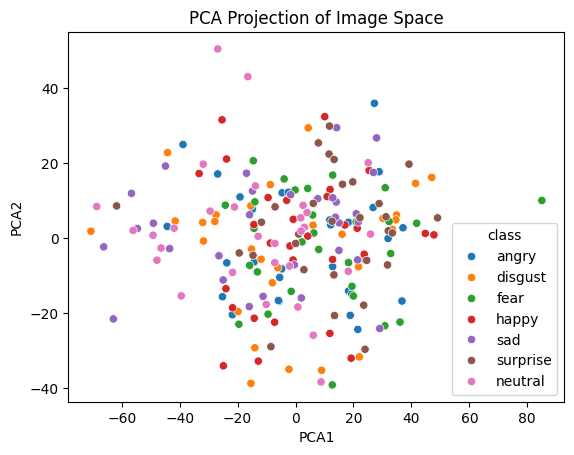

In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

# Flatten images for PCA/t-SNE
samples, labels = [], []
for cls in EMOTIONS:
    for img_name in os.listdir(os.path.join(TRAIN_DIR, cls))[:30]:
        img = Image.open(os.path.join(TRAIN_DIR, cls, img_name)).convert("L").resize((48, 48))
        samples.append(np.array(img).flatten())
        labels.append(cls)

scaled = StandardScaler().fit_transform(samples)
pca = PCA(n_components=2).fit_transform(scaled)

df_pca = pd.DataFrame(pca, columns=["PCA1", "PCA2"])
df_pca["class"] = labels

sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="class")
plt.title("PCA Projection of Image Space")
plt.show()


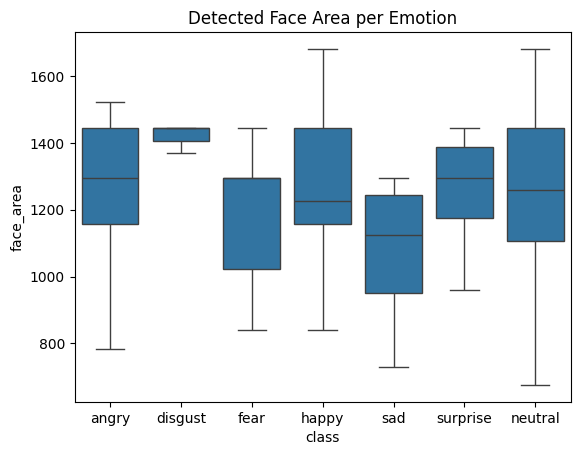

In [5]:
face_sizes = []
import cv2
import pandas as pd
import seaborn as sns
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
for cls in EMOTIONS:
    emo_path = os.path.join(TRAIN_DIR, cls)
    for img_name in os.listdir(emo_path)[:1000]:
        path = os.path.join(emo_path, img_name)
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x, y, w, h) in faces:
            face_sizes.append((cls, w * h))

df_faces = pd.DataFrame(face_sizes, columns=["class", "face_area"])
sns.boxplot(x="class", y="face_area", data=df_faces)
plt.title("Detected Face Area per Emotion")
plt.show()
